In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers import SimpleRNN
from keras import initializers
from keras.optimizers import RMSprop

%matplotlib inline

Using TensorFlow backend.


### Data 로드

In [2]:
df1 = pd.read_csv("C:/Users/dgpar/Desktop/TermProject/training_set.csv", low_memory=False)
df2 = pd.read_csv("C:/Users/dgpar/Desktop/TermProject/training_set_metadata.csv", low_memory=False)
idf = pd.merge(df2,df1)
print(df1.head(5))

   object_id         mjd  passband        flux   flux_err  detected
0        615  59750.4229         2 -544.810303   3.622952         1
1        615  59750.4306         1 -816.434326   5.553370         1
2        615  59750.4383         3 -471.385529   3.801213         1
3        615  59750.4450         4 -388.984985  11.395031         1
4        615  59752.4070         2 -681.858887   4.041204         1


### Train, Test set 분리

In [3]:
group = dict(list(df1.groupby("object_id")))

In [4]:
target = sorted(set(group))
#print(target)

In [5]:
tlist = []
for i in target:
    tlist.append(group[(i)])

In [6]:
#train = tlist[0:5232]
#test = tlist[5232:7848]
train = tlist[0:7048]
test = tlist[7048:7848]

### 로그변환. 로그변환 전, 음수값의 양수화 필요.

In [31]:
test[0].head(5)

,object_id,mjd,passband,flux,flux_err,detected
1318991,112835319,59629.2620,4,5.056978,6.981145,0
1318992,112835319,59652.1643,5,15.631347,24.459475,0
1318993,112835319,59653.1856,5,16.557280,32.410519,0
1318994,112835319,59654.1524,5,-36.669472,23.586477,0
1318995,112835319,59662.3230,3,2.192997,5.904088,0


### 하이퍼 파라미터 설정

In [7]:
batch_size = 32 # 32
num_classes = 15 #14
epochs = 1
hidden_units = 100

learning_rate = 1e-3
clip_norm = 1.0

### Zero padding으로 Train set shape 통일

In [260]:
#tlist[10] = tlist[10].ix[:,2:]
#tlist[20] = tlist[20].ix[:,2:]
#tlist[30] = tlist[30].ix[:,2:]
#tlist[40] = tlist[40].ix[:,2:]
#tlist[50] = tlist[50].ix[:,2:]

In [261]:
print(tlist[10].shape)
print(tlist[20].shape)
print(tlist[30].shape)
print(tlist[40].shape)
print(tlist[50].shape)

(351, 4)
(255, 4)
(352, 4)
(352, 4)
(350, 4)


In [8]:
#train_x = tlist[0:5232]
#max_len = np.max([len(a) for a in tlist])
train_x = tlist[0:7048]
max_len = np.max([len(a) for a in tlist])

In [9]:
add = np.array([0,0,0,0])

In [10]:
#declare nptest
nptest = train_x[0].ix[:,2:].values 
for i in range(0,1) :
    if len(nptest) != max_len:
        nptest = np.vstack((train_x[i].ix[:,2:].values, add))
    for a in range(0,max_len-len(nptest)) : #train[i]
        nptest = np.vstack((nptest, add))
        #print(a.ix[:,1:].values)
    train_x[i] = nptest
    
    

for i in range(1,len(train)) :
    if len(train[i]) != max_len:
        nptest = np.vstack((train_x[i].ix[:,2:].values, add))
    for a in range(0,max_len-(len(train[i])+1)) : #train[i]
        nptest = np.vstack((nptest, add))
        #print(a.ix[:,1:].values)
    train_x[i] = nptest

In [11]:
train_x = np.asarray(train_x)

In [13]:
train_x.shape

(7048, 352, 4)

In [268]:
print(train_x[10])

[[  2.        19.92598    0.644723   1.      ]
 [  1.        10.902653   0.626443   1.      ]
 [  3.        16.612894   1.066034   1.      ]
 ..., 
 [  4.        -0.229792   1.930554   0.      ]
 [  5.        -3.49103    4.417979   0.      ]
 [  0.         0.         0.         0.      ]]


In [14]:
len(train_x[7])

352

### Zero padding으로 Test set shape 통일

In [12]:
#test = tlist[5232:7848]
test = tlist[7048:7848]

In [13]:
#test_x = tlist[5232:7848]
test_x = tlist[7048:7848]
for i in range(0,len(test)) :
    if len(test[i] != max_len):
        nptest = np.vstack((test_x[i].ix[:,2:].values, add))
    for a in range(1,max_len-len(test[i])) : 
        nptest = np.vstack((nptest, add))
        #print(a.ix[:,1:].values)
    test_x[i] = nptest

In [14]:
test_x = np.asarray(test_x)

In [59]:
test_x.shape

(800, 352, 4)

### Train, Test set의 y값 설정

In [18]:
print(len(df1))
print(len(df2))

1421705
7848


In [19]:
df1[350:360]

,object_id,mjd,passband,flux,flux_err,detected
350,615,60624.2022,4,235.489929,3.926538,1
351,615,60624.2132,5,157.080200,8.453112,1
352,713,59825.2600,2,9.110147,1.013889,0
353,713,59825.2676,1,7.615042,1.160329,1
354,713,59825.2752,3,6.673631,1.932316,1
355,713,59825.2862,4,5.214194,3.018003,0
356,713,59825.2971,5,12.060948,7.163382,0
357,713,59839.2161,2,4.953065,1.196956,0
358,713,59839.2236,1,3.131028,1.351706,0
359,713,59839.2313,3,6.108739,1.789895,0


In [15]:
y = np.array(df2['target'])
y

array([92, 88, 42, ..., 16, 65,  6], dtype=int64)

In [17]:
set(y)

{6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95}

In [16]:
# y값을 0~95 size에서 0~14 size로 축소.
for i in range(0,len(df2)):
    if (y[i] == 6) :
        y[i] = 1
    elif(y[i] == 15) :
        y[i] = 2
    elif (y[i] == 16) :
        y[i] = 3
    elif (y[i] == 42) :
        y[i] = 4
    elif (y[i] == 52) :
        y[i] = 5
    elif (y[i] == 53) :
        y[i] = 6
    elif (y[i] == 62) :
        y[i] = 7
    elif (y[i] == 64) :
        y[i] = 8
    elif (y[i] == 65) :
        y[i] = 9
    elif (y[i] == 67) :
        y[i] = 10
    elif (y[i] == 88) :
        y[i] = 11
    elif (y[i] == 90) :
        y[i] = 12
    elif (y[i] == 92) :
        y[i] = 13
    elif (y[i] == 95) :
        y[i] = 14

In [17]:
#train_y = y[0:5232]
#test_y = y[5232:7848]
train_y = y[0:7048]
test_y = y[7048:7848]

In [20]:
train_y

array([13, 11,  4, ...,  3,  2, 13], dtype=int64)

In [18]:
train_y = keras.utils.to_categorical(train_y, 15)
test_y = keras.utils.to_categorical(test_y, 15)

In [22]:
train_y[1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.])

### Modeling

model = Sequential()
model.add(SimpleRNN(hidden_units,
                   kernel_initializer=initializers.RandomNormal(stddev=0.001),
                   recurrent_initializer=initializers.Identity(gain=1.0),
                   activation='relu',
                   input_shape=(None,5))) # make 784 x 1 shape from (60000,784,1). in our project it is (5)   
#model.add(Dense(num_classes))
model.add(Dense(15))
model.add(Activation('softmax'))
rmsprop = RMSprop(lr=learning_rate) # RMSprop is changed form of stochastic gradient descent 
model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [19]:
import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model

tweet_a = Input(shape=train_x.shape[1:])
tweet_b = Input(shape=train_x.shape[1:])
tweet_c = Input(shape=train_x.shape[1:])

In [20]:
shared_lstm = LSTM(64)

# When we reuse the same layer instance
# multiple times, the weights of the layer
# are also being reused
# (it is effectively *the same* layer)
encoded_a = shared_lstm(tweet_a)
encoded_b = shared_lstm(tweet_b)
encoded_c = shared_lstm(tweet_c)

# We can then concatenate the two vectors:
merged_vector = keras.layers.concatenate([encoded_a, encoded_b, encoded_c], axis=-1)


### Use last model

In [ ]:
'''from keras.models import load_model

# And add a logistic regression on top
predictions = Dense(15, activation='softmax')(merged_vector)#original one was activation = 'sigmoid'


# We define a trainable model linking the
# tweet inputs to the predictions

model = Model(inputs=[tweet_a, tweet_b, tweet_c], outputs=predictions)

model.load_weights('3node_lstm_weights2.h5')
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              '''

In [21]:
# And add a logistic regression on top
predictions = Dense(15, activation='softmax')(merged_vector)#original one was activation = 'sigmoid'


# We define a trainable model linking the
# tweet inputs to the predictions
model = Model(inputs=[tweet_a, tweet_b, tweet_c], outputs=predictions)
#keras.layers.Dropout(0.3, noise_shape=None, seed=None)

model.load_weights('3node_lstm_weights_val_200.h5')
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# 170~200
model.fit([train_x[0:6000], train_x[0:6000], train_x[0:6000]], train_y[0:6000], epochs=30, verbose=1,
          validation_data=([train_x[6000:7048],train_x[6000:7048], train_x[6000:7048]], train_y[6000:7048]))
model.save_weights('3node_lstm_weights_val_200.h5')

Train on 6000 samples, validate on 1048 samples
Epoch 1/30
6000/6000 [==============================] - 188s - loss: 0.9318 - acc: 0.6937 - val_loss: 1.0834 - val_acc: 0.6641

In [28]:
# 200~210
model.fit([train_x[0:6000], train_x[0:6000], train_x[0:6000]], train_y[0:6000], epochs=10, verbose=1,
          validation_data=([train_x[6000:7048],train_x[6000:7048], train_x[6000:7048]], train_y[6000:7048]))
model.save_weights('3node_lstm_weights_val_210.h5')

Train on 6000 samples, validate on 1048 samples
Epoch 1/10
6000/6000 [==============================] - 301s - loss: 0.8639 - acc: 0.7140 - val_loss: 1.1023 - val_acc: 0.6508

In [77]:
model.save_weights('3node_lstm_weights_val_150.h5')

In [22]:
#200
scores = model.evaluate([test_x, test_x, test_x], test_y, verbose=2)
print(scores)
print('test score:', scores[0])
print('test accuracy:', scores[1])

[1.0639822530746459, 0.67749999999999999]
test score: 1.06398225307
test accuracy: 0.6775


In [29]:
#210(val_acc 0.669)
scores = model.evaluate([test_x, test_x, test_x], test_y, verbose=2) # original is 0
#It should be test_x, test_y
print(scores)
print('test score:', scores[0])
print('test accuracy:', scores[1])

[1.0894778370857239, 0.66749999999999998]
test score: 1.08947783709
test accuracy: 0.6675


In [284]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 352, 4)        0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 352, 4)        0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 352, 4)        0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 64)            17664                                        
___________________________________________________________________________________________

In [235]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 352, 4)        0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 352, 4)        0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 352, 4)        0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 64)            17664                                        
___________________________________________________________________________________________

### Model Output class 확인

In [47]:
type(test_x)

numpy.ndarray

In [48]:
test_x.shape

(800, 352, 4)

In [49]:
train_x.shape

(7048, 352, 4)

In [59]:
np.vstack((train_x, test_x)).shape

(7848, 352, 4)

In [23]:
total_x = np.vstack((train_x, test_x))

In [55]:
train_x[0]

array([[   2.      , -544.810303,    3.622952,    1.      ],
       [   1.      , -816.434326,    5.55337 ,    1.      ],
       [   3.      , -471.385529,    3.801213,    1.      ],
       ..., 
       [   3.      ,  296.946533,    3.475   ,    1.      ],
       [   4.      ,  235.489929,    3.926538,    1.      ],
       [   5.      ,  157.0802  ,    8.453112,    1.      ]])

In [54]:
test_x[0]

array([[  4.      ,   5.056978,   6.981145,   0.      ],
       [  5.      ,  15.631347,  24.459475,   0.      ],
       [  5.      ,  16.55728 ,  32.410519,   0.      ],
       ..., 
       [  0.      ,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      ]])

In [62]:
total_x[0][0]

array([   2.      , -544.810303,    3.622952,    1.      ])

In [24]:
res = model.predict([total_x,total_x,total_x], verbose=0)

In [25]:
res

array([[  1.92143759e-10,   9.50302638e-06,   7.59242837e-08, ...,
          4.81958352e-02,   9.41097677e-01,   8.74663215e-07],
       [  1.00030900e-10,   1.27908133e-03,   6.55560052e-06, ...,
          1.90725755e-02,   5.99808982e-06,   1.27482872e-05],
       [  2.14733422e-11,   7.50164909e-05,   1.43725669e-03, ...,
          1.43373981e-01,   7.15595670e-04,   3.46796168e-03],
       ..., 
       [  4.57240669e-12,   5.87985152e-04,   1.79809362e-07, ...,
          6.18414051e-05,   3.58713977e-03,   9.54036477e-06],
       [  2.59527073e-13,   9.33251795e-05,   9.71805434e-07, ...,
          2.13889696e-04,   1.60086547e-05,   2.12394141e-07],
       [  6.90499090e-12,   6.66247159e-02,   1.05704632e-04, ...,
          5.15951402e-03,   6.08019643e-02,   4.19676024e-03]], dtype=float32)

In [34]:
tSeries = res.argmax(axis=-1)

In [34]:
tSeries

array([12, 12, 12, 13, 12, 12, 12, 12,  9, 12, 12,  3, 12,  9, 12, 12, 12,
       12,  9, 12,  9,  9, 12,  9,  9,  4, 12,  9, 12, 12, 12, 12,  1, 12,
       14, 11,  4,  9,  4, 12, 14,  9, 12,  1, 12, 12,  4,  9,  9, 14,  3,
       12, 12, 12,  3,  9, 12,  9,  9, 12, 13,  3,  9, 12,  9, 12,  9, 12,
       12, 11, 12, 12,  9,  4,  4, 12, 12,  3, 11,  3,  9,  3, 12,  4, 12,
        4, 12,  4, 12, 12, 12, 12, 12, 12,  9, 12,  3,  3,  3,  9, 11, 12,
        3,  9, 12, 12,  3, 12, 12,  9,  3, 12, 12, 11,  9, 12,  9,  9,  1,
       14, 12,  3, 12,  9, 12, 12, 12,  4,  3, 12, 12,  3,  9,  3, 12, 12,
       13,  3, 12, 13, 13,  9, 12, 14, 12, 12, 12, 12, 12,  9,  9,  9, 12,
       12, 12, 12, 11, 12,  9,  3,  9,  9, 13, 11, 12,  9, 12, 12,  9,  9,
       12,  9,  9, 12, 12,  3, 12,  4,  3, 12, 14, 11, 12, 11, 12, 12, 12,
       12, 12, 12, 12, 11, 12, 12, 11,  4, 12, 12, 12, 12, 12, 12,  3, 12,
        9, 12,  3, 12,  1,  4, 11,  3,  3,  9, 11, 12, 12,  4,  9, 13,  3,
       13, 11, 12, 11,  3

In [ ]:
shared_lstm = LSTM(64)

# When we reuse the same layer instance
# multiple times, the weights of the layer
# are also being reused
# (it is effectively *the same* layer)
encoded_a = shared_lstm(tweet_a, dropout=0.3)
encoded_b = shared_lstm(tweet_b)
encoded_c = shared_lstm(tweet_c)

# We can then concatenate the two vectors:
merged_vector = keras.layers.concatenate([encoded_a, encoded_b, encoded_c], axis=-1)

# And add a logistic regression on top
predictions = Dense(15, activation='softmax')(merged_vector)#original one was activation = 'sigmoid'


# We define a trainable model linking the
# tweet inputs to the predictions
model = Model(inputs=[tweet_a, tweet_b, tweet_c], outputs=predictions)
#keras.layers.Dropout(0.3, noise_shape=None, seed=None)

model.load_weights('3node_lstm_weights_val_200.h5')
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [289]:
# And add a logistic regression on top
predictions = Dense(15, activation='softmax')(tweet_c)#original one was activation = 'sigmoid'


# We define a trainable model linking the
# tweet inputs to the predictions
model = Model(inputs=tweet_c, outputs=predictions)
#keras.layers.Dropout(0.3, noise_shape=None, seed=None)

#model.load_weights('3node_lstm_weights_val_200.h5')
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_x[0:6000], train_y[0:6000], epochs=5, verbose=1,
          validation_data=(train_x[6000:7048], train_y[6000:7048]))

ValueError: Error when checking model target: expected dense_9 to have 3 dimensions, but got array with shape (6000, 15)

In [ ]:
#MyTry
model = Sequential()
model.add(LSTM(hidden_units,input_shape=(None,4), dropout=0.3)) # make 784 x 1 shape from (60000,784,1). in our project it is (5)   
model.add(Dense(15))
model.add(Activation('softmax'))
rmsprop = RMSprop(lr=learning_rate) # RMSprop is changed form of stochastic gradient descent 
model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

# ML Part

### Data Transformation

In [35]:
df2.isnull().sum()

object_id                0
ra                       0
decl                     0
gal_l                    0
gal_b                    0
ddf                      0
hostgal_specz            0
hostgal_photoz           0
hostgal_photoz_err       0
distmod               2325
mwebv                    0
target                   0
dtype: int64

In [35]:
df2['distmod'].replace(np.NaN, 0, inplace=True)
df2 = df2.drop(['object_id'], axis=1)

### Log 변환

In [39]:
#Check minus value
print(df2['ra'].min())
print(df2['decl'].min())
print(df2['gal_l'].min())
print(df2['gal_b'].min())
print(df2['ddf'].min())
print(df2['hostgal_specz'].min())
print(df2['hostgal_photoz'].min())
print(df2['hostgal_photoz_err'].min())
print(df2['distmod'].min())
print(df2['mwebv'].min())

0.175781
-64.760857
0.107681
-89.615573
0
0.0
0.0
0.0
0.0
0.003


In [36]:
df2['decl'] = df2['decl'] - df2['decl'].min()
df2['gal_b'] = df2['gal_b'] - df2['gal_b'].min()
df2 = df2 + 0.001

### Dataframe to Numpy

In [216]:
df2 = df2.drop(['target'], axis=1)
df2.head

<bound method NDFrame.head of               ra       decl       gal_l       gal_b    ddf  hostgal_specz  \
0     349.047051   2.818021  320.797530   37.862867  1.001         0.0010   
1      53.086938  36.977452  223.526509   35.155825  1.001         1.8191   
2      33.575219  58.182264  170.456585   28.068354  1.001         0.2330   
3       0.190873  19.175202  328.255458   20.647275  1.001         0.3047   
4     352.712273   0.938199  316.923299   38.557170  1.001         0.1944   
5      35.684594  59.382478  171.993947   30.363072  1.001         0.0010   
6     347.847710   0.001000  318.930827   40.472977  1.001         0.1362   
7     348.596886   1.689237  320.024289   38.903513  1.001         0.6867   
8     149.415062  68.195691  234.920132  131.862123  1.001         0.3098   
9     149.415062  66.701929  236.566366  131.009896  1.001         0.0010   
10      0.966665  18.386777  325.846907   21.037146  1.001         0.1526   
11    346.501000   2.441457  321.952129   38.8

In [217]:
x = np.array(df2)
log_x = np.log(x)

In [43]:
log_x.shape

(7848, 11)

In [65]:
tSeries.shape

(7848,)

### Data 병합

In [218]:
log_x.shape

(7848, 10)

In [76]:
log_x[0]

array([  5.85520673e+00,   1.03603487e+00,   5.77081018e+00,
         3.63397087e+00,   9.99500333e-04,  -6.90775528e+00,
        -6.90775528e+00,  -6.90775528e+00,  -6.90775528e+00,
        -4.01738352e+00,   4.52179945e+00])

In [77]:
tSeries[0]

13

In [91]:
np.reshape(tSeries,(7848,1))

array([[13],
       [11],
       [12],
       ..., 
       [11],
       [ 9],
       [ 1]], dtype=int64)

In [219]:
tSeries2d = np.reshape(tSeries,(7848,1))

In [96]:
log_x

array([[ 5.85520673,  1.03603487,  5.77081018, ..., -6.90775528,
        -4.01738352,  4.52179945],
       [ 3.97193091,  3.61030832,  5.40953002, ...,  3.81567289,
        -4.82831374,  4.47734818],
       [ 3.51378827,  4.06358057,  5.13848063, ...,  3.69528639,
        -3.81671283,  3.73769343],
       ..., 
       [ 5.31374332,  2.20604258,  5.7324668 , ..., -6.90775528,
        -0.84164719,  2.77265122],
       [ 4.37074526,  3.37622177,  5.47718816, ..., -6.90775528,
        -3.35240722,  4.17440265],
       [ 5.71040446,  3.85726126,  3.22302672, ..., -6.90775528,
        -2.3859667 ,  1.79192612]])

In [139]:
np.hstack((log_x,tSeries2d))

array([[  5.85520673,   1.03603487,   5.77081018, ...,  -4.01738352,
          4.52179945,  13.        ],
       [  3.97193091,   3.61030832,   5.40953002, ...,  -4.82831374,
          4.47734818,  11.        ],
       [  3.51378827,   4.06358057,   5.13848063, ...,  -3.81671283,
          3.73769343,   4.        ],
       ..., 
       [  5.31374332,   2.20604258,   5.7324668 , ...,  -0.84164719,
          2.77265122,   3.        ],
       [  4.37074526,   3.37622177,   5.47718816, ...,  -3.35240722,
          4.17440265,   9.        ],
       [  5.71040446,   3.85726126,   3.22302672, ...,  -2.3859667 ,
          1.79192612,   3.        ]])

In [220]:
np.vstack((log_x[1:100], log_x[100:150])).shape

(149, 10)

In [221]:
xValues=np.hstack((log_x,tSeries2d))

In [213]:
xValues

array([[  5.85520673,   1.03603487,   5.77081018, ...,  -4.01738352,
          4.52179945,  13.        ],
       [  3.97193091,   3.61030832,   5.40953002, ...,  -4.82831374,
          4.47734818,  11.        ],
       [  3.51378827,   4.06358057,   5.13848063, ...,  -3.81671283,
          3.73769343,   4.        ],
       ..., 
       [  5.31374332,   2.20604258,   5.7324668 , ...,  -0.84164719,
          2.77265122,   3.        ],
       [  4.37074526,   3.37622177,   5.47718816, ...,  -3.35240722,
          4.17440265,   9.        ],
       [  5.71040446,   3.85726126,   3.22302672, ...,  -2.3859667 ,
          1.79192612,   3.        ]])

### PCA

In [279]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# n_components 전체를 살펴보면서 각 변수별 영향력 파악.
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(xValues)
pca.explained_variance_ratio_

array([ 0.58321595,  0.19953261,  0.12337552,  0.02449918,  0.02099861,
        0.01781902,  0.01207491,  0.00835055,  0.00614171,  0.00232198,
        0.00166996])

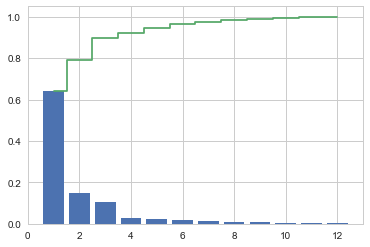

In [105]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA

pca_plot = PCA().fit(xValues)
var = pca.explained_variance_
cmap = sns.color_palette()

plt.bar(np.arange(1,len(var)+1), var/np.sum(var), align="center", color=cmap[0])
plt.step(np.arange(1,len(var)+1), np.cumsum(var)/np.sum(var), where="mid", color=cmap[1])
plt.show()

In [223]:
pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]\
+pca.explained_variance_ratio_[2]+pca.explained_variance_ratio_[3]\
+pca.explained_variance_ratio_[4]+pca.explained_variance_ratio_[5]\
+pca.explained_variance_ratio_[5]

0.96944088011174234

In [281]:
pcaSum=0
for i in range(0,9):
    pcaSum = pcaSum+pca.explained_variance_ratio_[i]
print(pcaSum)

0.996008053185


In [305]:
pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(xValues[0:7048])
X_test_pca = pca.transform(xValues[7048:])

### Without Timeseries data

In [270]:
pca_plot = PCA().fit(log_x)
var = pca.explained_variance_
cmap = sns.color_palette()

pca = PCA(n_components=7)
train_pca = pca.fit_transform(log_x[0:7048])
test_pca = pca.transform(log_x[7048:])

#Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

tree = DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=0)
tree.fit(train_pca, train_y)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [271]:
dt_y_pred = tree.predict(test_pca) # train data의 성능

print(accuracy_score(test_y, dt_y_pred))

0.32375


In [299]:
print(classification_report(test_y, dt_y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.05      0.05      0.05        20
          2       0.17      0.12      0.14        82
          3       0.43      0.47      0.45       100
          4       0.23      0.28      0.25       107
          5       0.00      0.00      0.00        20
          6       0.00      0.00      0.00         5
          7       0.11      0.13      0.12        39
          8       0.16      0.16      0.16        19
          9       0.55      0.43      0.48       107
         10       0.00      0.00      0.00        20
         11       0.24      0.20      0.22        35
         12       0.47      0.49      0.48       208
         13       0.03      0.05      0.04        20
         14       0.47      0.44      0.46        18

avg / total       0.33      0.32      0.32       800



c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [233]:
forest = RandomForestClassifier(criterion = 'entropy', n_estimators=10, random_state = 1, n_jobs=2)
forest.fit(train_pca, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [234]:
rf_y_pred = forest.predict(test_pca) # train data의 성능

print(accuracy_score(test_y, rf_y_pred))

0.20625


In [300]:
print(classification_report(test_y, rf_y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00        20
          2       0.67      0.02      0.05        82
          3       0.51      0.39      0.44       100
          4       0.24      0.07      0.10       107
          5       0.00      0.00      0.00        20
          6       0.00      0.00      0.00         5
          7       0.00      0.00      0.00        39
          8       0.00      0.00      0.00        19
          9       0.58      0.35      0.43       107
         10       0.00      0.00      0.00        20
         11       0.29      0.06      0.10        35
         12       0.61      0.37      0.46       208
         13       0.00      0.00      0.00        20
         14       1.00      0.11      0.20        18

avg / total       0.44      0.21      0.26       800



c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Including LSTM TS Data Without PCA

In [105]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=0)
tree.fit(xValues[0:7048], train_y)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [106]:
OriginTS_DT_y_pred = tree.predict(xValues[7048:]) # train data의 성능

print(accuracy_score(test_y, OriginTS_DT_y_pred))

1.0


In [98]:
# component6
print(classification_report(test_y, OriginTS_DT_y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      1.00      1.00        20
          2       1.00      1.00      1.00        82
          3       1.00      1.00      1.00       100
          4       1.00      1.00      1.00       107
          5       1.00      1.00      1.00        20
          6       1.00      1.00      1.00         5
          7       1.00      1.00      1.00        39
          8       1.00      1.00      1.00        19
          9       1.00      1.00      1.00       107
         10       1.00      1.00      1.00        20
         11       1.00      1.00      1.00        35
         12       1.00      1.00      1.00       208
         13       1.00      1.00      1.00        20
         14       1.00      1.00      1.00        18

avg / total       1.00      1.00      1.00       800



c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Without LSTM TS data & PCA

In [101]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=0)
tree.fit(log_x[0:7048], train_y)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
tree.fit(log_x[0:7048], train_y)


In [102]:
Origin_DT_y_pred = tree.predict(log_x[7048:]) # train data의 성능

print(accuracy_score(test_y, Origin_DT_y_pred))

1.0


### Without LSTM TS data & PCA & Log Transformation

In [207]:
df22 = df2.drop(['target'], axis=1)

In [208]:
x1 = np.array(df22)

tree = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=0)
tree.fit(x1[0:7048], train_y)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [209]:
NoLT_DT_y_pred = tree.predict(x1[7048:]) # train data의 성능

print(accuracy_score(test_y, NoLT_DT_y_pred))
print(classification_report(test_y, NoLT_DT_y_pred))

0.3125
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.29      0.20      0.24        20
          2       0.19      0.12      0.15        82
          3       0.45      0.45      0.45       100
          4       0.24      0.18      0.21       107
          5       0.06      0.05      0.05        20
          6       0.00      0.00      0.00         5
          7       0.17      0.13      0.14        39
          8       0.30      0.16      0.21        19
          9       0.55      0.39      0.46       107
         10       0.07      0.05      0.06        20
         11       0.33      0.29      0.31        35
         12       0.54      0.50      0.52       208
         13       0.00      0.00      0.00        20
         14       0.35      0.39      0.37        18

avg / total       0.37      0.31      0.34       800



c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [210]:
forest = RandomForestClassifier(criterion = 'entropy', n_estimators=10, random_state = 1, n_jobs=2)
forest.fit(x1[0:7048], train_y)
fr_y_pred = tree.predict(x1[7048:]) # train data의 성능

print(accuracy_score(test_y, fr_y_pred))

0.3125


### File Writing

In [ ]:
dfw = pd.DataFrame(NoLT_DT_y_pred)
dfw.columns = ["class_99", "class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95"]

cols = dfw.columns.tolist()
cols = cols[1:] + cols[:1]
dfw = dfw[cols]
dfw.to_csv("testWriting.csv", mode='a')

In [126]:
dfw = pd.DataFrame(NoLT_DT_y_pred)
dfw.columns = ["class_99", "class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95"]


In [127]:
dfw

,class_99,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
cols = dfw.columns.tolist()
cols

['class_99',
 'class_6',
 'class_15',
 'class_16',
 'class_42',
 'class_52',
 'class_53',
 'class_62',
 'class_64',
 'class_65',
 'class_67',
 'class_88',
 'class_90',
 'class_92',
 'class_95']

In [130]:
cols = cols[1:] + cols[:1]
cols

['class_6',
 'class_15',
 'class_16',
 'class_42',
 'class_52',
 'class_53',
 'class_62',
 'class_64',
 'class_65',
 'class_67',
 'class_88',
 'class_90',
 'class_92',
 'class_95',
 'class_99']

In [132]:
dfw = dfw[cols]

In [133]:
dfw

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
# 이전에 object_id concatenate 해야함.
# object_id는 오름차순으로 ordering 해야함.
dfw.to_csv("testWriting.csv")
#dfw.to_csv("testWriting.csv", mode='a')

In [136]:
dfw

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
i = 0
for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set_metadata.csv", chunksize=100000):
    print(chunk.isnull().sum())
    chunk['hostgal_specz'].replace(np.NaN, 0, inplace=True)#Need to Check
    chunk['distmod'].replace(np.NaN, 0, inplace=True)
    if i == 0:
        x = np.array(chunk)
        object_id = list(chunk['object_id'])
        i = i+1
    else:
        x = np.vstack((x,np.array(chunk)))
        object_id = object_id.append(chunk['object_id'])
        i=i+1
    #print(chunk.head())
    #print(object_id)
    if i >1:
        break;
    #break;

In [ ]:
i = 0
for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set_metadata.csv", chunksize=100000):
    print(chunk.isnull().sum())
    chunk['hostgal_specz'].replace(np.NaN, 0, inplace=True)#Need to Check
    chunk['distmod'].replace(np.NaN, 0, inplace=True)
    if i == 0:
        x = np.array(chunk)
        object_id = list(chunk['object_id'])
        i = i+1
    else:
        x = np.vstack((x,np.array(chunk)))
        object_id = object_id.append(chunk['object_id'])
        i=i+1
    #print(chunk.head())
    #print(object_id)
    if i >1:
        break;
    #break;

In [193]:
i = 0
for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set_metadata.csv", chunksize=100000):
    print(chunk.isnull().sum())
    chunk['hostgal_specz'].replace(np.NaN, 0, inplace=True)#Need to Check
    chunk['distmod'].replace(np.NaN, 0, inplace=True)
    if i == 0:
        x = np.array(chunk)
        object_id = list(chunk['object_id'])
        i = i+1
        #print(object_id)
    else:
        x = np.vstack((x,np.array(chunk)))
        object_id = np.append(object_id, list(chunk['object_id']))
        i=i+1
    #print(chunk.head())
    #print(object_id)
    if i >1:
        #print(object_id)
        break;
    #break;

object_id                 0
ra                        0
decl                      0
gal_l                     0
gal_b                     0
ddf                       0
hostgal_specz         87385
hostgal_photoz            0
hostgal_photoz_err        0
distmod                7792
mwebv                     0
dtype: int64
object_id                 0
ra                        0
decl                      0
gal_l                     0
gal_b                     0
ddf                       0
hostgal_specz         96872
hostgal_photoz            0
hostgal_photoz_err        0
distmod               11431
mwebv                     0
dtype: int64


In [195]:
i = 0
for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set_metadata.csv", chunksize=100000):
    print(chunk.isnull().sum())
    chunk['hostgal_specz'].replace(np.NaN, 0, inplace=True)#Need to Check
    chunk['distmod'].replace(np.NaN, 0, inplace=True)
    if i == 0:
        #x = np.array(chunk)
        object_id = list(chunk['object_id'])
        x = np.array(chunk.drop(['object_id'], axis=1))
        i = i+1
        #print(object_id)
    else:
        object_id = np.append(object_id, list(chunk['object_id']))        
        x = np.vstack((x,np.array(chunk.drop(['object_id'], axis=1))))
        i=i+1
    #print(chunk.head())
    #print(object_id)
    if i >1:
        #print(object_id)
        break;
    #break;

object_id                 0
ra                        0
decl                      0
gal_l                     0
gal_b                     0
ddf                       0
hostgal_specz         87385
hostgal_photoz            0
hostgal_photoz_err        0
distmod                7792
mwebv                     0
dtype: int64
object_id                 0
ra                        0
decl                      0
gal_l                     0
gal_b                     0
ddf                       0
hostgal_specz         96872
hostgal_photoz            0
hostgal_photoz_err        0
distmod               11431
mwebv                     0
dtype: int64


In [196]:
aax = pd.DataFrame(x[1:10])
aax

,0,1,2,3,4,5,6,7,8,9
0,33.398438,-4.331149,167.226341,-59.936551,1.0,0.0000,0.6323,0.0179,42.8774,0.018
1,348.529419,-61.755440,321.293980,-51.763351,1.0,0.0000,0.8297,0.0605,43.6000,0.016
2,34.804688,-5.829153,171.307861,-60.174401,1.0,0.0000,0.6533,0.1479,42.9640,0.023
3,351.321442,-64.198746,317.458993,-50.429931,1.0,0.4557,0.4617,0.0122,42.0540,0.023
4,35.332031,-5.979157,172.286722,-59.931743,1.0,0.0000,0.8388,0.0375,43.6290,0.022
5,0.574468,-45.981140,327.041068,-68.778764,1.0,0.0000,0.6669,0.0546,43.0186,0.006
6,0.574468,-45.981140,327.041068,-68.778764,1.0,0.0000,1.4663,0.0529,45.1281,0.006
7,346.562500,-63.448284,320.824720,-49.866957,1.0,0.0000,0.9462,0.0116,43.9519,0.021
8,349.160583,-64.760857,318.219706,-49.458924,1.0,0.0000,1.0432,0.1092,44.2138,0.020


In [198]:
aax.shape

(9, 10)

In [203]:
aax_res = tree.predict(aax) # train data의 성능
print(aax_res)
#print(accuracy_score(test_y, NoLT_DT_y_pred))
#print(classification_report(test_y, NoLT_DT_y_pred))

ValueError: Number of features of the model must match the input. Model n_features is 11 and input n_features is 10 

### TS test data for submission

In [243]:
i = 0
for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set.csv", chunksize=100000):
    #print(chunk.isnull().sum())
    group2 = dict(list(chunk.groupby("object_id")))
    target2 = sorted(set(group2))
    tlist2 = []
    for i in target2:
        tlist2.append(group2[(i)])
    
    #object_id 별로 묶어서, max arg값 구해보기.
    break;

In [244]:
tlist2

[     object_id         mjd  passband       flux  flux_err  detected
 0           13  59798.3205         2  -1.299735  1.357315         0
 1           13  59798.3281         1  -2.095392  1.148654         0
 2           13  59798.3357         3  -0.923794  1.763655         0
 3           13  59798.3466         4  -4.009815  2.602911         0
 4           13  59798.3576         5  -3.403503  5.367328         0
 5           13  59801.3553         2  -1.778855  2.448943         0
 6           13  59801.3629         1   2.491993  3.540421         0
 7           13  59801.3705         3   1.644129  2.284999         0
 8           13  59801.3815         4  -0.158192  2.515900         0
 9           13  59801.3924         5  -6.457387  5.381231         0
 10          13  59818.2740         0   1.962846  1.795587         0
 11          13  59819.2541         0  -1.697929  2.433431         0
 12          13  59820.2522         0  -1.698675  1.898612         0
 13          13  59821.2478       

In [236]:
aax

,0,1,2,3,4,5,6,7,8,9
0,33.398438,-4.331149,167.226341,-59.936551,1.0,0.0000,0.6323,0.0179,42.8774,0.018
1,348.529419,-61.755440,321.293980,-51.763351,1.0,0.0000,0.8297,0.0605,43.6000,0.016
2,34.804688,-5.829153,171.307861,-60.174401,1.0,0.0000,0.6533,0.1479,42.9640,0.023
3,351.321442,-64.198746,317.458993,-50.429931,1.0,0.4557,0.4617,0.0122,42.0540,0.023
4,35.332031,-5.979157,172.286722,-59.931743,1.0,0.0000,0.8388,0.0375,43.6290,0.022
5,0.574468,-45.981140,327.041068,-68.778764,1.0,0.0000,0.6669,0.0546,43.0186,0.006
6,0.574468,-45.981140,327.041068,-68.778764,1.0,0.0000,1.4663,0.0529,45.1281,0.006
7,346.562500,-63.448284,320.824720,-49.866957,1.0,0.0000,0.9462,0.0116,43.9519,0.021
8,349.160583,-64.760857,318.219706,-49.458924,1.0,0.0000,1.0432,0.1092,44.2138,0.020


In [241]:
total_x.shape

(7848, 352, 4)

In [ ]:
res = model.predict([aax,total_x,total_x], verbose=0)
result = res.argmax(axis=-1)

In [151]:
i = 0
for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set_metadata.csv", chunksize=100000):
    print(chunk['distmod'])
    break;

0        41.1123
1        42.8774
2        43.6000
3        42.9640
4        42.0540
5        43.6290
6        43.0186
7        45.1281
8        43.9519
9        44.2138
10       39.4929
11       41.4711
12       43.6747
13       43.5011
14       43.8114
15       44.4151
16       41.2464
17       44.7444
18       40.8738
19       42.3075
20           NaN
21       43.7031
22       41.9820
23       41.4450
24       43.8508
25       43.9062
26       42.0768
27       41.6579
28       42.2594
29       42.5781
          ...   
99970        NaN
99971    42.8072
99972    41.6521
99973    42.1143
99974    42.1225
99975    43.6856
99976    43.3703
99977    41.2474
99978    40.0650
99979    40.1395
99980    43.5812
99981        NaN
99982    43.0107
99983    39.1196
99984    43.0144
99985    43.1169
99986    43.3150
99987    40.1959
99988    42.9120
99989    39.2799
99990    40.7765
99991    40.9834
99992        NaN
99993    40.9997
99994        NaN
99995        NaN
99996    43.8782
99997    42.57

In [ ]:
x.shape

In [138]:
x.shape

(7848, 11)

### Including LSTM TS Data

In [306]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

tree = DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=0)
tree.fit(X_train_pca, train_y)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [307]:
# component6
DT_y_pred = tree.predict(X_test_pca) 
print(classification_report(test_y, DT_y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.60      0.60      0.60        20
          2       0.68      0.60      0.64        82
          3       0.92      0.90      0.91       100
          4       0.37      0.36      0.37       107
          5       0.00      0.00      0.00        20
          6       0.00      0.00      0.00         5
          7       0.13      0.18      0.15        39
          8       0.67      0.63      0.65        19
          9       0.93      0.96      0.94       107
         10       0.11      0.10      0.10        20
         11       0.83      0.86      0.85        35
         12       0.63      0.62      0.63       208
         13       0.55      0.55      0.55        20
         14       0.52      0.67      0.59        18

avg / total       0.62      0.62      0.62       800



c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [308]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_y, DT_y_pred))

0.62


In [292]:
print(accuracy_score(test_y, DT_y_pred))

0.62


In [296]:
from sklearn.ensemble import RandomForestClassifier

#Adapting Random Forest
forest = RandomForestClassifier(criterion = 'entropy', n_estimators=10, random_state = 1, n_jobs=2)
forest.fit(X_train_pca, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [297]:
# component6
RF_y_pred = forest.predict(X_test_pca) # train data의 성능
print(classification_report(test_y, RF_y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.68      0.65      0.67        20
          2       0.92      0.66      0.77        82
          3       0.93      0.93      0.93       100
          4       0.46      0.30      0.36       107
          5       0.00      0.00      0.00        20
          6       0.00      0.00      0.00         5
          7       0.36      0.13      0.19        39
          8       0.86      0.63      0.73        19
          9       0.95      0.97      0.96       107
         10       0.00      0.00      0.00        20
         11       0.91      0.86      0.88        35
         12       0.69      0.53      0.60       208
         13       0.72      0.65      0.68        20
         14       0.79      0.61      0.69        18

avg / total       0.71      0.60      0.64       800



c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [298]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_y, RF_y_pred))

0.5975


In [91]:
from sklearn.svm import SVC

#SVM
svm = SVC(gamma='scale', decision_function_shape='ovo')
#svm = SVC(kernel = 'rbf' , random_state = 0, gamma = 0.10 , C = 10.0)
svm.fit(X_train_pca ,o a)#y[0:7048].astype(float))#train_y)

TypeError: a float is required

In [90]:
a = y[0:7048].astype(float)

In [76]:
X_train_pca.shape

(7048, 7)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

#Decision Tree
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
tree.fit(X_train_pca, y_train)
#Adapting Random Forest
forest = RandomForestClassifier(criterion = 'entropy', n_estimators=10, random_state = 1, n_jobs=2)
forest.fit(X_train_pca, y_train)

#SVM
svm = SVC(kernel = 'rbf' , random_state = 0, gamma = 0.10 , C = 10.0)
svm.fit(X_train_pca , y_train)

#Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_pca, y_train)

In [121]:
DT_y_pred

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])

In [123]:
# component6
print(classification_report(test_y, DT_y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.47      0.45      0.46        20
          2       0.00      0.00      0.00        82
          3       0.94      0.79      0.86       100
          4       0.00      0.00      0.00       107
          5       0.00      0.00      0.00        20
          6       0.00      0.00      0.00         5
          7       0.00      0.00      0.00        39
          8       0.00      0.00      0.00        19
          9       0.90      0.92      0.91       107
         10       0.00      0.00      0.00        20
         11       0.87      0.57      0.69        35
         12       0.58      0.32      0.41       208
         13       0.75      0.75      0.75        20
         14       0.92      0.67      0.77        18

avg / total       0.48      0.37      0.41       800



c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [126]:
# component6
print(classification_report(test_y, DT_y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.47      0.45      0.46        20
          2       0.00      0.00      0.00        82
          3       0.94      0.79      0.86       100
          4       0.00      0.00      0.00       107
          5       0.00      0.00      0.00        20
          6       0.00      0.00      0.00         5
          7       0.00      0.00      0.00        39
          8       0.00      0.00      0.00        19
          9       0.90      0.92      0.91       107
         10       0.00      0.00      0.00        20
         11       0.87      0.57      0.69        35
         12       0.58      0.32      0.41       208
         13       0.75      0.75      0.75        20
         14       0.92      0.67      0.77        18

avg / total       0.48      0.37      0.41       800



c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\dgpar\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [180]:
tree.predict_proba(X_test_pca)[14][0][0] # class num, ith, prob 

0.99848254931714719

### test dataset

In [127]:
for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set.csv", chunksize=10000):
    print(chunk.head(5))

   object_id         mjd  passband      flux  flux_err  detected
0         13  59798.3205         2 -1.299735  1.357315         0
1         13  59798.3281         1 -2.095392  1.148654         0
2         13  59798.3357         3 -0.923794  1.763655         0
3         13  59798.3466         4 -4.009815  2.602911         0
4         13  59798.3576         5 -3.403503  5.367328         0
       object_id         mjd  passband      flux  flux_err  detected
10000        216  60427.0278         4 -2.705358  3.422914         0
10001        216  60427.0388         5 -0.253956  7.836624         0
10002        216  60430.9870         2  1.540200  0.776160         0
10003        216  60430.9946         1  0.594447  0.751387         0
10004        216  60431.0022         3 -1.444294  1.232042         0
       object_id         mjd  passband      flux  flux_err  detected
20000        607  59842.0207         2  0.932102  1.043969         0
20001        607  59842.0285         1 -0.967062  1.053545

KeyboardInterrupt: 

### Save model

In [50]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one

#model = load_model('my_model.h5')

### Save model weights

In [51]:
model.save_weights('my_model_weights.h5')

### delete mode lto check usage

In [130]:
del model

### Use last model

### Referring site of save_model & save_weight

https://keras.io/getting-started/faq/

앞으로 할일.
1) 머신러닝 코드 만들기
2) 변수변환 및 스케일링
3) class 하나더 추가하기
4) 모델 성능 개선(LSTM 모델 추가할 수 있는지 or 다른모델은? 등등 알아보기.)
-> Kaggle 답안지 업로드

In [137]:
model.save_weights('3node_lstm_weights2.h5')

### Model Output Class 확인

In [29]:
res = model.predict([test_x,test_x,test_x], verbose=0)

In [30]:
res

array([[  3.09014792e-09,   4.43312526e-03,   6.43046647e-02, ...,
          2.83205837e-01,   2.22813862e-04,   2.65325769e-03],
       [  1.16290078e-09,   2.56220251e-02,   1.20718494e-01, ...,
          3.09537292e-01,   2.70146760e-04,   4.07715961e-02],
       [  7.34543981e-09,   1.11227371e-02,   6.13066852e-02, ...,
          2.60320067e-01,   3.46243061e-04,   8.61536991e-03],
       ..., 
       [  2.62888200e-09,   1.91512808e-01,   6.81339065e-03, ...,
          2.02576648e-02,   3.13387136e-03,   1.42848445e-02],
       [  3.29635097e-10,   8.18662345e-03,   8.50534439e-03, ...,
          6.67858273e-02,   8.85029222e-05,   3.49827780e-04],
       [  1.11733767e-09,   3.30832541e-01,   4.39312495e-02, ...,
          1.07946277e-01,   1.01857295e-03,   3.08816060e-02]], dtype=float32)

In [31]:
res.argmax(axis=-1)

array([12, 12, 12, 13, 12, 12, 12, 12,  9, 12, 12,  3, 12,  9, 12, 12, 12,
       12,  9, 12,  9,  9, 12,  9,  9,  4, 12,  9, 12, 12, 12, 12,  1, 12,
       14, 11,  4,  9,  4, 12, 14,  9, 12,  1, 12, 12,  4,  9,  9, 14,  3,
       12, 12, 12,  3,  9, 12,  9,  9, 12, 13,  3,  9, 12,  9, 12,  9, 12,
       12, 11, 12, 12,  9,  4,  4, 12, 12,  3, 11,  3,  9,  3, 12,  4, 12,
        4, 12,  4, 12, 12, 12, 12, 12, 12,  9, 12,  3,  3,  3,  9, 11, 12,
        3,  9, 12, 12,  3, 12, 12,  9,  3, 12, 12, 11,  9, 12,  9,  9,  1,
       14, 12,  3, 12,  9, 12, 12, 12,  4,  3, 12, 12,  3,  9,  3, 12, 12,
       13,  3, 12, 13, 13,  9, 12, 14, 12, 12, 12, 12, 12,  9,  9,  9, 12,
       12, 12, 12, 11, 12,  9,  3,  9,  9, 13, 11, 12,  9, 12, 12,  9,  9,
       12,  9,  9, 12, 12,  3, 12,  4,  3, 12, 14, 11, 12, 11, 12, 12, 12,
       12, 12, 12, 12, 11, 12, 12, 11,  4, 12, 12, 12, 12, 12, 12,  3, 12,
        9, 12,  3, 12,  1,  4, 11,  3,  3,  9, 11, 12, 12,  4,  9, 13,  3,
       13, 11, 12, 11,  3

In [118]:
df2['target'].value_counts()

90    2313
42    1193
65     981
16     924
15     495
62     484
88     370
92     239
67     208
52     183
95     175
6      151
64     102
53      30
Name: target, dtype: int64

In [ ]:
df2.ix[0:7048,:]['target'].value_counts()

In [119]:
2313/7848

0.2947247706422018

In [ ]:
dfw = pd.DataFrame(NoLT_DT_y_pred)
dfw.columns = ["class_99", "class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95"]


### Making submission data

In [29]:
num = 0
temp = 0
temp_list = []
rowSum =0

for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set.csv", chunksize=100000):
#    print(chunk.isnull().sum())
    
    group = dict(list(chunk.groupby("object_id")))
    target = sorted(set(group))
    testlist = []
    #myList = []
    for i in target:
        testlist.append(group[(i)])
        #myList.append(group[(i)])
    
    max_len = np.max([len(a) for a in testlist])
    
    
    ###zero padding
    add = np.array([0,0,0,0])

    #declare nptest
    nptest = testlist[0].ix[:,2:].values 
    for i in range(0,1) :
        if temp == list(set(testlist[0]["object_id"]))[0]:
            nptest = np.vstack((temp_list,testlist[0]))
#        else : #else문으로 이전 chunk의 마지막 object_id != 새 chunk의 첫 object_id 처리 필요
#            testlist = 
        
        if len(nptest) != max_len:
            nptest = np.vstack((testlist[i].ix[:,2:].values, add))
        for a in range(0,max_len-len(nptest)) : #train[i]
            nptest = np.vstack((nptest, add))
            #print(a.ix[:,1:].values)
        testlist[i] = nptest
    
    

    for i in range(1,len(testlist)) :
        if len(testlist[i]) != max_len:
            nptest = np.vstack((testlist[i].ix[:,2:].values, add))
        for a in range(0,max_len-(len(testlist[i])+1)) : #train[i]
            nptest = np.vstack((nptest, add))
            #print(a.ix[:,1:].values)
        testlist[i] = nptest
    
    #if(num==5):
    #    print(testlist[:-1])
    #print(len(testlist[:-1]))
    testlist = np.asarray(testlist[:-1])
    rowSum += len(testlist)
    #previous df & next df concatenate
    ###temp = list(set(myList[-1]["object_id"]))[0]
    ###temp_list = myList[-1]
    
    if(rowSum < 3492890) :
        ###predict
        res = model.predict([testlist,testlist,testlist], verbose=0)



        ###file write
        dfw = pd.DataFrame(res)
        dfw.columns = ["class_99", "class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95"]

        cols = dfw.columns.tolist()
        cols = cols[1:] + cols[:1]
        dfw = dfw[cols]

        obj_id = pd.DataFrame(target)
        dfw["object_id"] = obj_id

        dfw.columns = ["class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95","class_99","object_id"]
        cols2 = dfw.columns.tolist()
        #print(cols2)
        cols2 = cols2[15:] + cols2[:15]
        #print(cols2)
        dfw = dfw[cols2]

        if num == 0 :
            dfw.to_csv("submission.csv", index=False)
            #num = num+1
        else :
            dfw.to_csv("submission.csv", mode='a', header=False, index=False)

    #    if(max_len != 352):
    #        print(max_len)
        num = num+1
    #    print(num)
    #    if(num%100==0):
    #        print(num)
        #print(num)
        if(num%1000 == 0) : 
            print(rowSum)
            #break
    else :
        testlist = np.asarray(testlist[:(len(testlist)-(rowSum-3492890))])
        ###predict
        res = model.predict([testlist,testlist,testlist], verbose=0)



        ###file write
        dfw = pd.DataFrame(res)
        dfw.columns = ["class_99", "class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95"]

        cols = dfw.columns.tolist()
        cols = cols[1:] + cols[:1]
        dfw = dfw[cols]

        obj_id = pd.DataFrame(target)
        dfw["object_id"] = obj_id

        dfw.columns = ["class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95","class_99","object_id"]
        cols2 = dfw.columns.tolist()
        #print(cols2)
        cols2 = cols2[15:] + cols2[:15]
        #print(cols2)
        dfw = dfw[cols2]

        if num == 0 :
            dfw.to_csv("submission.csv", index=False)
            #num = num+1
        else :
            dfw.to_csv("submission.csv", mode='a', header=False, index=False)

        #if(max_len != 352):
        #    print(max_len)
        num = num+1
    #    print(num)
    #    if(num%100==0):
    #        print(num)
        #print(num)
        if(num%1000 == 0) : 
            print(rowSum)
            #break

ValueError: Error when checking : expected input_1 to have shape (None, 352, 4) but got array with shape (782, 169, 4)

In [ ]:
#save before make rowSum
num = 0
temp = 0
temp_list = []
rowSum =0

for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set.csv", chunksize=100000):
#    print(chunk.isnull().sum())
    
    group = dict(list(chunk.groupby("object_id")))
    target = sorted(set(group))
    testlist = []
    #myList = []
    for i in target:
        testlist.append(group[(i)])
        #myList.append(group[(i)])
    
    max_len = np.max([len(a) for a in testlist])
    
    
    ###zero padding
    add = np.array([0,0,0,0])

    #declare nptest
    nptest = testlist[0].ix[:,2:].values 
    for i in range(0,1) :
        if temp == list(set(testlist[0]["object_id"]))[0]:
            nptest = np.vstack((temp_list,testlist[0]))
#        else : #else문으로 이전 chunk의 마지막 object_id != 새 chunk의 첫 object_id 처리 필요
#            testlist = 
        
        if len(nptest) != max_len:
            nptest = np.vstack((testlist[i].ix[:,2:].values, add))
        for a in range(0,max_len-len(nptest)) : #train[i]
            nptest = np.vstack((nptest, add))
            #print(a.ix[:,1:].values)
        testlist[i] = nptest
    
    

    for i in range(1,len(testlist)) :
        if len(testlist[i]) != max_len:
            nptest = np.vstack((testlist[i].ix[:,2:].values, add))
        for a in range(0,max_len-(len(testlist[i])+1)) : #train[i]
            nptest = np.vstack((nptest, add))
            #print(a.ix[:,1:].values)
        testlist[i] = nptest
    
    #if(num==5):
    #    print(testlist[:-1])
    #print(len(testlist[:-1]))
    testlist = np.asarray(testlist[:-1])
    rowSum += len(testlist)
    #previous df & next df concatenate
    ###temp = list(set(myList[-1]["object_id"]))[0]
    ###temp_list = myList[-1]
    
    
    ###predict
    res = model.predict([testlist,testlist,testlist], verbose=0)
    
    
    
    ###file write
    dfw = pd.DataFrame(res)
    dfw.columns = ["class_99", "class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95"]

    cols = dfw.columns.tolist()
    cols = cols[1:] + cols[:1]
    dfw = dfw[cols]
    
    obj_id = pd.DataFrame(target)
    dfw["object_id"] = obj_id

    dfw.columns = ["class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95","class_99","object_id"]
    cols2 = dfw.columns.tolist()
    #print(cols2)
    cols2 = cols2[15:] + cols2[:15]
    #print(cols2)
    dfw = dfw[cols2]
    
    if num == 0 :
        dfw.to_csv("submission.csv", index=False)
        #num = num+1
    else :
        dfw.to_csv("submission.csv", mode='a', header=False, index=False)

    if(max_len != 352):
        print(max_len)
    num = num+1
#    print(num)
#    if(num%100==0):
#        print(num)
    #print(num)
    if(num%6 == 0) : 
        print(num)
        break


In [27]:
len(testlist)

304

In [159]:
myList[-1]

,object_id,mjd,passband,flux,flux_err,detected
599734,18864,59750.4229,2,-0.304347,1.512767,0
599735,18864,59750.4306,1,0.740947,2.120264,0
599736,18864,59750.4383,3,0.157322,2.310747,0
599737,18864,59750.4450,4,-1.293456,10.350690,0
599738,18864,59752.4070,2,-1.398085,1.069883,0
599739,18864,59752.4147,1,0.353043,1.114871,0
599740,18864,59752.4224,3,-1.413890,1.466534,0
599741,18864,59752.4334,4,2.167371,2.355925,0
599742,18864,59752.4435,5,2.818794,9.501709,0
599743,18864,59767.2968,2,0.221698,0.885733,0


In [ ]:
#save
num = 0
temp_prev = 0
temp_now = 0
temp_list = []
for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set.csv", chunksize=100000):
#    print(chunk.isnull().sum())
    
    group = dict(list(chunk.groupby("object_id")))
    target = sorted(set(group))
    testlist = []
    for i in target:
        testlist.append(group[(i)])
    
    max_len = np.max([len(a) for a in testlist])
    
    temp_now = list(set(testlist[-1]["object_id"]))[0]
    #temp_list = testlist[-1]
    
    ###zero padding
    add = np.array([0,0,0,0])

    #declare nptest
    nptest = testlist[0].ix[:,2:].values 
    for i in range(0,1) :
        if temp_prev == list(set(testlist[0]["object_id"]))[0]:
            nptest = np.vstack((temp_list,testlist[0]))
#        else : #else문으로 이전 chunk의 마지막 object_id != 새 chunk의 첫 object_id 처리 필요
#            testlist = 
        
        if len(nptest) != max_len:
            nptest = np.vstack((testlist[i].ix[:,2:].values, add))
        for a in range(0,max_len-len(nptest)) : #train[i]
            nptest = np.vstack((nptest, add))
            #print(a.ix[:,1:].values)
        testlist[i] = nptest
    
    

    for i in range(1,len(testlist)) :
        if len(testlist[i]) != max_len:
            nptest = np.vstack((testlist[i].ix[:,2:].values, add))
        for a in range(0,max_len-(len(testlist[i])+1)) : #train[i]
            nptest = np.vstack((nptest, add))
            #print(a.ix[:,1:].values)
        testlist[i] = nptest
    
    #if(num==5):
    #    print(testlist[:-1])
    #print(len(testlist[:-1]))
    testlist = np.asarray(testlist[:-1])
    
    ###predict
    res = model.predict([testlist,testlist,testlist], verbose=0)
    
    
    
    ###file write
    dfw = pd.DataFrame(res)
    dfw.columns = ["class_99", "class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95"]

    cols = dfw.columns.tolist()
    cols = cols[1:] + cols[:1]
    dfw = dfw[cols]
    
    obj_id = pd.DataFrame(target)
    dfw["object_id"] = obj_id

    dfw.columns = ["class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95","class_99","object_id"]
    cols2 = dfw.columns.tolist()
    #print(cols2)
    cols2 = cols2[15:] + cols2[:15]
    #print(cols2)
    dfw = dfw[cols2]
    
    if num == 0 :
        dfw.to_csv("testSubmission.csv")
        #num = num+1
    else :
        dfw.to_csv("submission.csv", mode='a', header=False)

    if(max_len != 352):
        print(max_len)
    num = num+1
#    print(num)
#    if(num%100==0):
#        print(num)
    #print(num)
    if(num%10 == 0) : 
        print(num)


In [151]:
testlist[-1]

array([[ 2.      , -0.312579,  1.35248 ,  0.      ],
       [ 1.      , -2.803587,  1.142799,  0.      ],
       [ 3.      , -2.814714,  1.758955,  0.      ],
       ..., 
       [ 0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ]])

In [143]:
aaa=[]
aaa.append(['1','2','3'])

In [144]:
aaa

[['1', '2', '3']]

In [131]:
np.array(testlist[:-1])

ValueError: could not broadcast input array from shape (352,6) into shape (352)

In [133]:
testlist[:-1]

[array([[  1.56340000e+04,   5.97504229e+04,   2.00000000e+00,
          -1.26881500e+00,   1.52021300e+00,   0.00000000e+00],
        [  1.56340000e+04,   5.97504306e+04,   1.00000000e+00,
          -4.75252500e+00,   2.13513700e+00,   0.00000000e+00],
        [  1.56340000e+04,   5.97504383e+04,   3.00000000e+00,
           3.09712800e+00,   2.32033600e+00,   0.00000000e+00],
        ..., 
        [  1.56340000e+04,   6.06241913e+04,   3.00000000e+00,
           6.98875400e+00,   2.20689500e+00,   0.00000000e+00],
        [  1.56340000e+04,   6.06242022e+04,   4.00000000e+00,
           9.97132700e+00,   3.04028200e+00,   0.00000000e+00],
        [  1.56340000e+04,   6.06242132e+04,   5.00000000e+00,
          -8.94957200e+00,   7.46820500e+00,   0.00000000e+00]]),
 array([[  1.56340000e+04,   5.97504229e+04,   2.00000000e+00,
          -1.26881500e+00,   1.52021300e+00,   0.00000000e+00],
        [  1.56340000e+04,   5.97504306e+04,   1.00000000e+00,
          -4.75252500e+00,   2.1

In [ ]:
306확인 (3028 두번)

In [111]:
len(res)

304

In [ ]:
610, 611확인 6000

In [72]:
testlist[0]

array([[  3.      ,  -0.748935,   1.531307,   0.      ],
       [  4.      ,   3.930673,   2.166217,   0.      ],
       [  5.      , -12.442091,   5.092499,   0.      ],
       ..., 
       [  0.      ,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      ]])

In [71]:
testlist[len(testlist)-1]

array([[ 2.      , -0.012017,  0.932113,  0.      ],
       [ 1.      , -0.784269,  1.01105 ,  0.      ],
       [ 3.      ,  0.027633,  1.872419,  0.      ],
       ..., 
       [ 0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ]])

In [65]:
res[0]

array([  4.26192458e-12,   4.38278657e-04,   3.23580716e-05,
         8.39314982e-03,   5.08511551e-02,   9.03373286e-02,
         7.31065156e-05,   2.04045083e-02,   5.11917551e-06,
         6.12608008e-02,   1.87131613e-02,   5.32873580e-03,
         7.40761459e-01,   1.85242633e-03,   1.54843647e-03], dtype=float32)

In [ ]:
###file write
    dfw = pd.DataFrame(res)
    dfw.columns = ["class_99", "class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95"]

    cols = dfw.columns.tolist()
    cols = cols[1:] + cols[:1]
    dfw = dfw[cols]
    obj_id = pd.DataFrame(target)
    dfw["object_id"] = obj_id
    
    dfw.columns = ["class_99", "class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95","object_id"]
    cols2 = dfw.columns.tolist()
    cols2 = cols2[16:] + cols2[:16]
    dfw = dfw[cols2]
    ##

In [44]:
obj_id = pd.DataFrame(target)
dfw["object_id"] = obj_id

,0
0,615
1,713
2,730
3,745
4,1124
5,1227
6,1598
7,1632
8,1920
9,1926


In [ ]:
#object_id 항목 추출


In [ ]:
#zero padding
add = np.array([0,0,0,0])

#declare nptest
nptest = testlist[0].ix[:,2:].values 
for i in range(0,1) :
    if len(nptest) != max_len:
        nptest = np.vstack((testlist[i].ix[:,2:].values, add))
    for a in range(0,max_len-len(nptest)) : #train[i]
        nptest = np.vstack((nptest, add))
        #print(a.ix[:,1:].values)
    testlist[i] = nptest
    
    

for i in range(1,len(testlist)) :
    if len(testlist[i]) != max_len:
        nptest = np.vstack((testlist[i].ix[:,2:].values, add))
    for a in range(0,max_len-(len(testlist[i])+1)) : #train[i]
        nptest = np.vstack((nptest, add))
        #print(a.ix[:,1:].values)
    testlist[i] = nptest
    
testlist = np.asarray(testlist)

In [ ]:
res = model.predict([testlist,testlist,testlist], verbose=0)

In [ ]:
total_x

In [40]:
len(testlist)

7848

### Save submission process

In [ ]:
num = 0
for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set.csv", chunksize=100000):
    group = dict(list(chunk.groupby("object_id")))
    target = sorted(set(group))
    testlist = []
    for i in target:
        testlist.append(group[(i)])
    
    max_len = np.max([len(a) for a in testlist])
    
    ###zero padding
    add = np.array([0,0,0,0])

    #declare nptest
    nptest = testlist[0].ix[:,2:].values 
    for i in range(0,1) :
        if len(nptest) != max_len:
            nptest = np.vstack((testlist[i].ix[:,2:].values, add))
        for a in range(0,max_len-len(nptest)) : #train[i]
            nptest = np.vstack((nptest, add))
            #print(a.ix[:,1:].values)
        testlist[i] = nptest
    
    

    for i in range(1,len(testlist)) :
        if len(testlist[i]) != max_len:
            nptest = np.vstack((testlist[i].ix[:,2:].values, add))
        for a in range(0,max_len-(len(testlist[i])+1)) : #train[i]
            nptest = np.vstack((nptest, add))
            #print(a.ix[:,1:].values)
        testlist[i] = nptest
    
    testlist = np.asarray(testlist)
    
    ###predict
    res = model.predict([testlist,testlist,testlist], verbose=0)
    
    
    
    ###file write
    dfw = pd.DataFrame(res)
    dfw.columns = ["class_99", "class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95"]

    cols = dfw.columns.tolist()
    cols = cols[1:] + cols[:1]
    dfw = dfw[cols]
    
    obj_id = pd.DataFrame(target)
    dfw["object_id"] = obj_id

    dfw.columns = ["class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95","class_99","object_id"]
    cols2 = dfw.columns.tolist()
    #print(cols2)
    cols2 = cols2[15:] + cols2[:15]
    #print(cols2)
    dfw = dfw[cols2]
    
    #dfw.columns = ["class_99", "class_6", "class_15", "class_16", "class_42", "class_52", "class_53", "class_62", "class_64", "class_65", "class_67", "class_88", "class_90", "class_92", "class_95","object_id"]
    #cols2 = dfw.columns.tolist()
    #cols2 = cols2[16:] + cols2[:16]
    #dfw = dfw[cols2]
    ##
    if num == 0 :
        dfw.to_csv("testSubmission.csv")
        #num = num+1
    else :
        dfw.to_csv("testSubmission.csv", mode='a', header=False)

    if(max_len != 352):
        print(max_len)
    num = num+1
    print(num)
    if(num>1) : 
        break

In [ ]:
num = 0
for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set.csv", chunksize=100000):
    group = dict(list(df1.groupby("object_id")))
    target = sorted(set(group))
    testlist = []
    for i in target:
        testlist.append(group[(i)])
    
    
max_len = np.max([len(a) for a in testlist])
print(max_len)
print(len(testlist))

# object_id 추출





#zero padding
add = np.array([0,0,0,0])

#declare nptest
nptest = testlist[0].ix[:,2:].values 
for i in range(0,1) :
    if len(nptest) != max_len:
        nptest = np.vstack((testlist[i].ix[:,2:].values, add))
    for a in range(0,max_len-len(nptest)) : #train[i]
        nptest = np.vstack((nptest, add))
        #print(a.ix[:,1:].values)
    testlist[i] = nptest
    
    

for i in range(1,len(testlist)) :
    if len(testlist[i]) != max_len:
        nptest = np.vstack((testlist[i].ix[:,2:].values, add))
    for a in range(0,max_len-(len(testlist[i])+1)) : #train[i]
        nptest = np.vstack((nptest, add))
        #print(a.ix[:,1:].values)
    testlist[i] = nptest
    
testlist = np.asarray(testlist)


In [28]:
i = 0
for chunk in pd.read_csv(
    "C:/Users/dgpar/Desktop/TermProject/test_set.csv", chunksize=100000):
    print(chunk.isnull().sum())
    '''chunk['hostgal_specz'].replace(np.NaN, 0, inplace=True)#Need to Check
    chunk['distmod'].replace(np.NaN, 0, inplace=True)
    if i == 0:
        #x = np.array(chunk)
        object_id = list(chunk['object_id'])
        x = np.array(chunk.drop(['object_id'], axis=1))
        i = i+1
        #print(object_id)
    else:
        object_id = np.append(object_id, list(chunk['object_id']))        
        x = np.vstack((x,np.array(chunk.drop(['object_id'], axis=1))))
        i=i+1
    #print(chunk.head())
    #print(object_id)
    if i >1:
        #print(object_id)
        break;
    #break;'''
    i = i+1
    if i>10 :
        break

object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64
object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64
object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64
object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64
object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64
object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64
object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64
object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64
object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64
object_id    0
mjd          0
passband     0
flux         0
flux_err     

In [ ]:
group = dict(list(df1.groupby("object_id")))
target = sorted(set(group))
testlist = []
for i in target:
    testlist.append(group[(i)])